In [1]:
import torch
print(torch.__version__)

2.5.1+cu121


In [2]:
!python --version

Python 3.10.12


In [3]:
import gc
import time

In [5]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output

  !pip install transformers evaluate wandb datasets accelerate -U peft bitsandbytes -qq

  basepath = '/content/drive/MyDrive/NLP UTD/'

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
!apt-get install -y ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 1s (80.5 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [7]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast
import evaluate
# New libraries introduced in this notebook

from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login


In [8]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [9]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


Successfully logged in to Hugging Face!


In [10]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [11]:
# Set the base folder path using the Path class for better path handling
base_folder = Path(basepath)

# Define the data folder path by appending the relative path to the base folder
# This is where the data files will be stored
data_folder = base_folder / 'datasets'

# Define the model folder path for saving trained models
# This path points to a specific folder designated for NLP models related to the IMDb dataset
model_folder = base_folder / 'models'

custom_functions = base_folder/'custom-functions'


In [12]:
train_data=pd.read_csv(data_folder/'train.csv')


In [13]:
train_data.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [14]:
import re
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and punctuation
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    return text


In [15]:
train_data['Tweet'] = train_data['Tweet'].apply(clean_text)

In [16]:
from sklearn.model_selection import train_test_split
# First split: 60% training and 40% (test + validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Check the shapes of the new datasets
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")

Training Data Shape: (6179, 13)
Validation Data Shape: (1545, 13)


In [17]:
train_data.shape,val_data.shape

((6179, 13), (1545, 13))

In [18]:
X_train=train_data['Tweet']
X_val=val_data['Tweet']

In [19]:
y_train = train_data[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                    'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.tolist()

y_valid = val_data[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                    'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.tolist()

In [20]:
X_train

,Tweet
4291,Going to get myself copy of StephenKing CUJO f...
1210,carysmithwriter Maria_Savva RealRockAndRoll W...
1940,Unruly kids at 8am in the morning nothanks rip...
6204,Ok but just got called White Devil on the trai...
2867,SXMUrbanView karenhunter CousinSyl you are so...
...,...
5226,I ve watched ScreamQueens 2nd Season 1st episo...
5390,Zero help from ups customer service Just pushi...
860,Scorpio always seek revenge
7603,jewleree GameOfThrones Lmao night king smiles


In [21]:
trainset = Dataset.from_dict({
    'texts': X_train,  # Your cleaned text data for training
    'labels': y_train           # Your multilabels for training
})

validset = Dataset.from_dict({
    'texts': X_val,  # Your cleaned text data for validation
    'labels': y_valid           # Your multilabels for validation
})

In [22]:
train_val_subset= DatasetDict(
    {"train": trainset, "valid": validset})

In [23]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['texts', 'labels'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['texts', 'labels'],
        num_rows: 1545
    })
})

In [24]:
train_val_subset['train']['labels'][0]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]

In [25]:
train_val_subset['train']['texts'][0]

'Going to get myself copy of StephenKing CUJO for an upcoming project that can talk about just yet amwriting'

In [26]:
train_val_subset['valid']['labels'][0]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]

In [27]:
train_val_subset['valid']['texts'][0]

'I due for big change ve prayed on it think deserve it positivity '

In [28]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [29]:
free_gpu_memory()

GPU memory has been freed.


In [30]:
checkpoint = "intfloat/e5-mistral-7b-instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [31]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

In [32]:
def tokenize_fn(batch):
    return tokenizer(text = batch["texts"], truncation=True, max_length=512)

In [33]:
tokenized_dataset= train_val_subset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['texts']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [34]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [35]:
tokenized_dataset['train']['labels'][0]

tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [36]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [37]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [38]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [39]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
                    'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model.config.pad_token_id = tokenizer.pad_token_id

In [41]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [42]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['q_proj',
 'o_proj',
 'gate_proj',
 'v_proj',
 'down_proj',
 'k_proj',
 'score',
 'up_proj']

In [43]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 335,589,376 || all params: 7,446,294,528 || trainable%: 4.5068


In [44]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MistralForSequenceClassification(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDi

In [45]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")


base_model.model.model.embed_tokens.weight: False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: True
base_model.model.model.layers.0.mlp.ga

In [46]:
import evaluate
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}


In [47]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/mistral_lora_imb")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'mistral_exp_imb_exp1'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [48]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

MistralConfig {
  "_name_or_path": "intfloat/e5-mistral-7b-instruct",
  "architectures": [
    "MistralModel"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 40

In [49]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [50]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [51]:
pos_weights

tensor([ 1.7018,  6.0216,  1.6576,  4.8403,  1.6657,  8.0734,  2.3256,  7.7274,
         2.4082, 17.9540, 19.0617])

In [52]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [53]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-53-fcc51a4c04a4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [54]:
%env WANDB_PROJECT = multilabel_mistral

env: WANDB_PROJECT=multilabel_mistral


In [55]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


wandb: Currently logged in as: mowvagangagovardhan14 (mowvagangagovardhan14-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
20,1.777400,1.078118,0.415045,0.322048,0.708091,0.012945
40,1.035100,0.933384,0.529021,0.466963,0.716387,0.018123
60,0.874300,0.855101,0.563320,0.498653,0.759164,0.082201
80,0.803700,0.766709,0.566680,0.526179,0.745337,0.062783
100,0.754600,0.769497,0.603033,0.544229,0.775110,0.077670
120,0.719700,0.747253,0.627841,0.561068,0.792821,0.096440
140,0.729200,0.715465,0.623838,0.568502,0.790527,0.094498
160,0.649400,0.754839,0.642578,0.577925,0.806178,0.099676
180,0.680600,0.749507,0.628848,0.567365,0.797117,0.095146
200,0.651900,0.694680,0.635049,0.577124,0.798058,0.108091


In [56]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [57]:
eval_results

{'eval_loss': 0.7549983263015747,
 'eval_f1_micro': 0.6577861605564069,
 'eval_f1_macro': 0.5893270543054537,
 'eval_accuracy_label': 0.8291850544277729,
 'eval_accuracy_all': 0.1546925566343042,
 'eval_runtime': 10.7327,
 'eval_samples_per_second': 143.953,
 'eval_steps_per_second': 9.038,
 'epoch': 1.994832041343669}

In [58]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

In [59]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [60]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [61]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [62]:
optimal_thresholds

[0.41704100370407104,
 0.5506073832511902,
 0.3415830433368683,
 0.6242935657501221,
 0.725645899772644,
 0.7248696088790894,
 0.4532618522644043,
 0.5936089754104614,
 0.5636181831359863,
 0.8122658133506775,
 0.6302298307418823]

In [63]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [64]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.6911987860394537,
 'f1_macro': 0.6180879993380975,
 'accuracy_label': 0.8563106796116505,
 'accuracy_all': 0.20970873786407768}

In [65]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[ 815  158]
  [  77  495]]

 [[1041  282]
  [  84  138]]

 [[ 752  197]
  [ 116  480]]

 [[1183   57]
  [  91  214]]

 [[ 909   77]
  [ 117  442]]

 [[1335   59]
  [  56   95]]

 [[ 883  229]
  [  54  379]]

 [[1196  162]
  [  78  109]]

 [[ 957  128]
  [ 152  308]]

 [[1440   35]
  [  44   26]]

 [[1309  144]
  [  45   47]]]


In [66]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


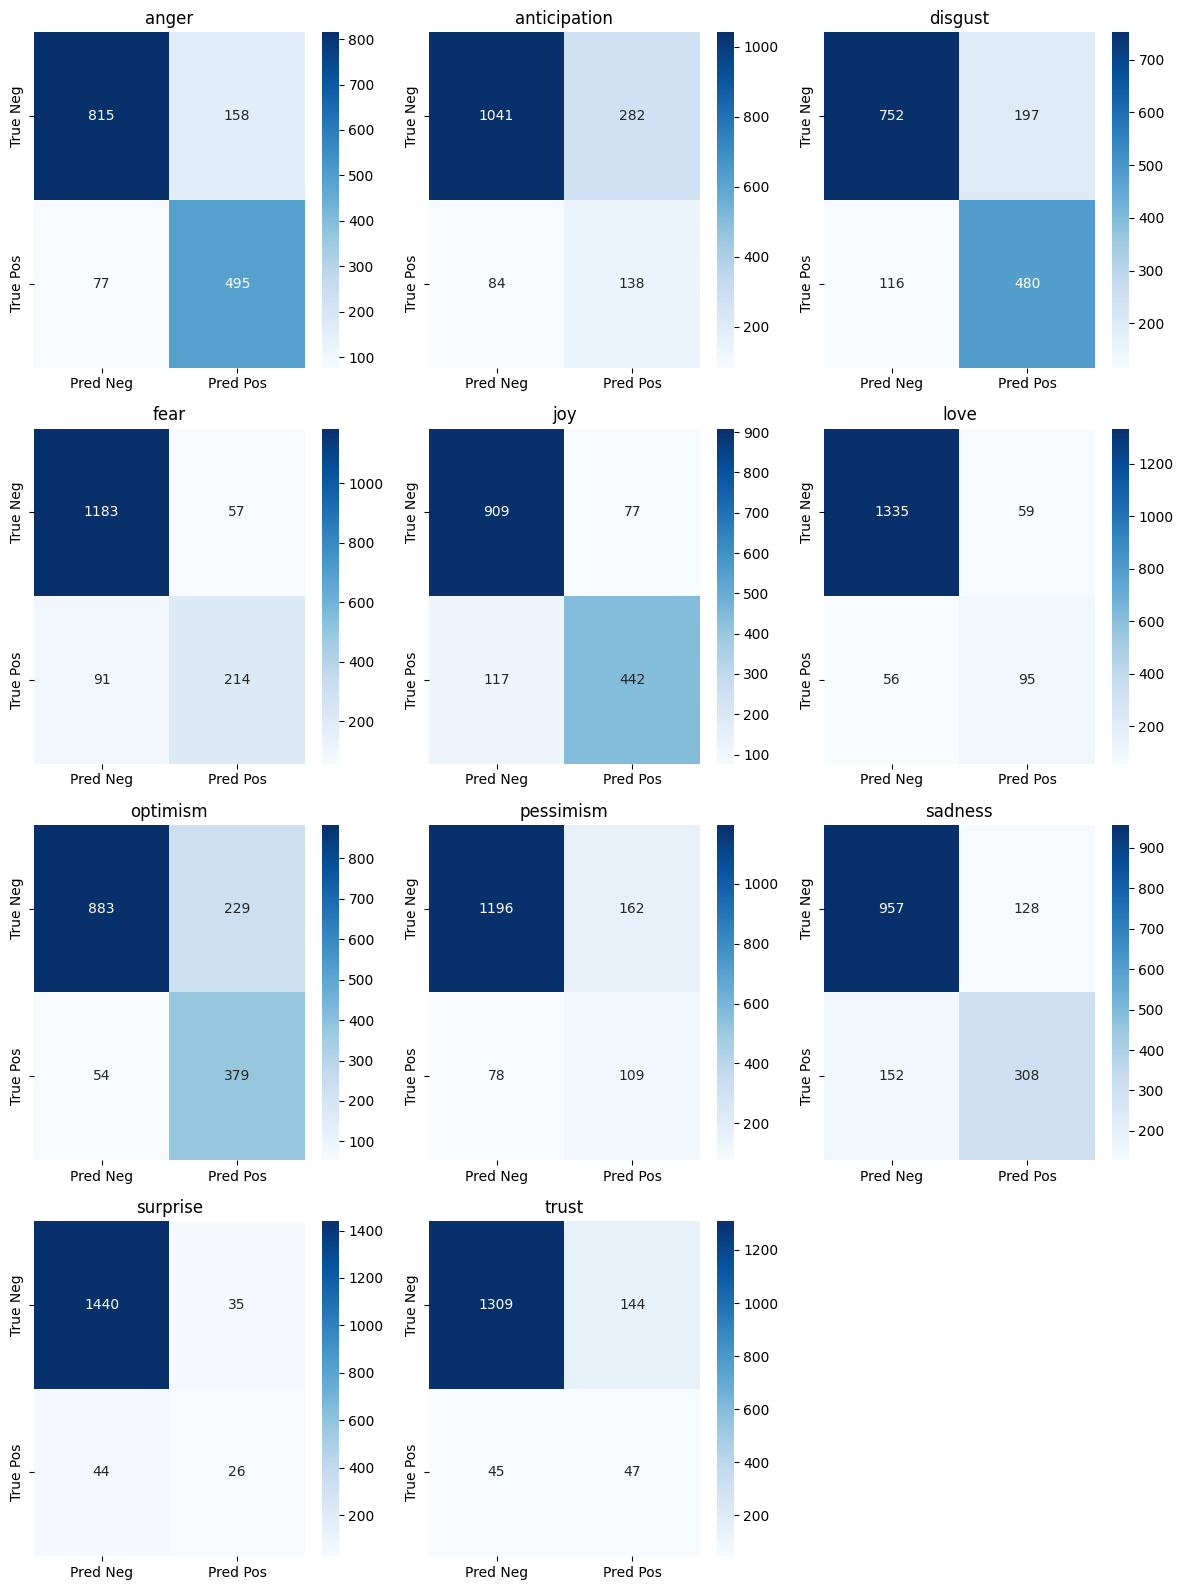

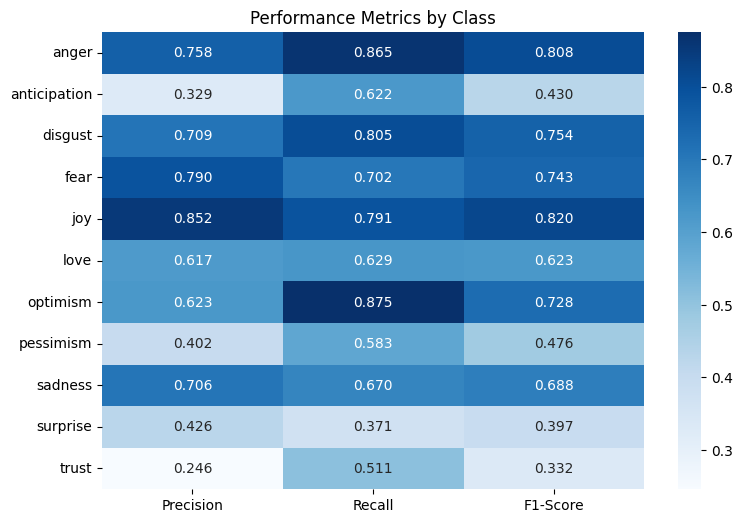

<Figure size 1200x533.333 with 0 Axes>

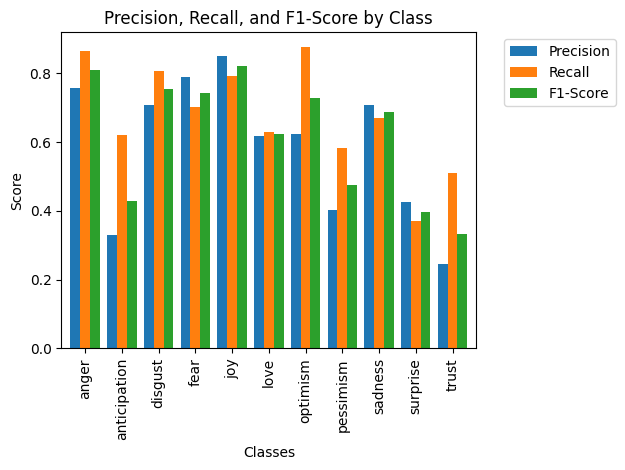

{'macro_avg': {'precision': 0.587100406664159,
  'recall': 0.6748991994751269,
  'f1': 0.6180879993380975},
 'per_class': {'Precision': {'anger': 0.7580398162327718,
   'anticipation': 0.32857142857142857,
   'disgust': 0.7090103397341211,
   'fear': 0.7896678966789668,
   'joy': 0.8516377649325626,
   'love': 0.6168831168831169,
   'optimism': 0.6233552631578947,
   'pessimism': 0.4022140221402214,
   'sadness': 0.7064220183486238,
   'surprise': 0.4262295081967213,
   'trust': 0.24607329842931938},
  'Recall': {'anger': 0.8653846153846154,
   'anticipation': 0.6216216216216216,
   'disgust': 0.8053691275167785,
   'fear': 0.7016393442622951,
   'joy': 0.7906976744186046,
   'love': 0.6291390728476821,
   'optimism': 0.8752886836027713,
   'pessimism': 0.5828877005347594,
   'sadness': 0.6695652173913044,
   'surprise': 0.37142857142857144,
   'trust': 0.5108695652173914},
  'F1-Score': {'anger': 0.8081632653061225,
   'anticipation': 0.42990654205607476,
   'disgust': 0.7541241162608

In [67]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

In [68]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 240.


In [69]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/mistral_lora_imb/checkpoint-240'

In [70]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig

In [71]:
model = AutoPeftModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,
)

peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model.config.use_cache = False
# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at intfloat/e5-mistral-7b-instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [72]:
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
model.config.id2label = id2label
model.config.label2id = label2id

In [73]:
custom_pipeline = pipeline(
    task="text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    function_to_apply='sigmoid')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
The model 'PeftModelForSequenceClassification' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequ

In [74]:
test_data=pd.read_csv(data_folder/'test.csv')

In [75]:
test_data['Tweet'] = test_data['Tweet'].apply(clean_text)

In [76]:
test_data

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,Adnan__786__ AsYouNotWish Dont worry Indian a...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,Academy of Sciences eschews the normally sober...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,I blew that opportunity __ mad,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,This time in 2 weeks will be 30,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,Deppression is real Partners depressed people...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,shaft abrasions from panties merely shifted to...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3255,2018-00416,lomadia heard of Remothered Indie horror game...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3256,2018-03717,All this fake outrage all need to stop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3257,2018-03504,Would be ever so grateful if you could record ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [77]:

y = test_data.drop(columns=['ID', 'Tweet']).replace('NONE', 0)
y_test = y.values.tolist()  # Convert to list of lists


testset = Dataset.from_dict({
    'text': test_data['Tweet'].tolist(),  # Convert Series to list
    'labels': y_test  # Multilabels for test set
})



<ipython-input-77-14b42cb074d1>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = test_data.drop(columns=['ID', 'Tweet']).replace('NONE', 0)


In [78]:
preds = custom_pipeline(testset['text'], truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [79]:
import pandas as pd

def get_positive_labels(pipeline_output, thresholds, class_names):
    """
    Extracts positive labels from pipeline output and ensures consistent columns
    using specific thresholds for each class.

    Args:
        pipeline_output: The output from the Hugging Face pipeline.
        thresholds: A list of thresholds for each class, ordered as per class_names.
        class_names: A list of all possible class names.

    Returns:
        A list of dictionaries, where each dictionary represents a sample
        and contains the positive labels and their scores.
    """
    positive_labels = []

    # Convert thresholds to dictionary if passed as a list
    if isinstance(thresholds, list):
        thresholds = dict(zip(class_names, thresholds))

    for pred_set in pipeline_output:
        sample_positives = {}
        # Initialize all class scores to 0
        for class_name in class_names:
            sample_positives[class_name] = 0
        # Update scores for positive predictions based on specific thresholds
        for pred in pred_set:
            threshold = thresholds.get(pred['label'], 0.5)  # Default to 0.5 if not specified
            if pred['score'] >= threshold:
                sample_positives[pred['label']] = 1
        positive_labels.append(sample_positives)

    return positive_labels

# Example usage with 'preds' and 'class_names' defined, along with 'optimal_thresholds'


In [80]:
results = get_positive_labels(preds, thresholds=optimal_thresholds, class_names=class_names)
predicted_labels = pd.DataFrame(results)


In [81]:
predicted_labels

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,1,1,0,0,0,0,1,1,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,1,0,0,0,0
4,1,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3254,1,0,1,0,0,0,0,0,0,0,0
3255,0,1,0,0,0,0,1,0,0,0,0
3256,1,0,1,0,0,0,0,1,0,0,0
3257,0,1,0,0,1,0,1,0,0,0,1


In [82]:
predicted_labels.insert(0, 'ID', test_data['ID'])
result_df = predicted_labels

In [83]:
result_df.to_csv(data_folder/'submission_exp2_mistral.csv', index=False)

In [84]:
result_df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,1,0,0,0,0,1,1,0,0,0
1,2018-03739,1,1,0,0,0,0,1,0,0,0,0
2,2018-00385,1,0,0,0,0,0,1,0,0,0,0
3,2018-03001,1,0,0,0,1,0,1,0,0,0,0
4,2018-01988,1,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,1,0,1,0,0,0,0,0,0,0,0
3255,2018-00416,0,1,0,0,0,0,1,0,0,0,0
3256,2018-03717,1,0,1,0,0,0,0,1,0,0,0
3257,2018-03504,0,1,0,0,1,0,1,0,0,0,1
